# Лабораторная работа №6

## Анализ и прогнозирование временного ряда.

### Задание:

1. Выберите набор данных (датасет) для решения задачи прогнозирования временного ряда.
2. Визуализируйте временной ряд и его основные характеристики.
3. Разделите временной ряд на обучающую и тестовую выборку.
4. Произведите прогнозирование временного ряда с использованием как минимум двух методов.
5. Визуализируйте тестовую выборку и каждый из прогнозов.
6. Оцените качество прогноза в каждом случае с помощью метрик.

Для работы используется набор данных, содержащий ежемесячные данные о количестве пассажиров, перевезенных одной американской авиакомпанией с 1949 по 1960 годы.

In [97]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import GridSearchCV
from gplearn.genetic import SymbolicRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [98]:
# загрузка данных
df = pd.read_csv('passengers.csv')

### Основные характеристики датасета

In [65]:
# Выведем первые 5 строк из выбранного датасета.
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [66]:
# превратим дату в индекс и сделаем изменение постоянным
df.set_index('Month', inplace = True)
df.head()

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [67]:
# превратим дату (наш индекс) в объект datetime
df.index = pd.to_datetime(df.index)
 
# посмотрим на первые пять дат и на тип данных
df.index[:5]

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01'],
              dtype='datetime64[ns]', name='Month', freq=None)

In [68]:
df.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


### Визуализация временного ряда

[Text(0.5, 1.0, 'Минимальные суточные с 1949 по 1960 год'),
 Text(0.5, 0, 'Месяцы'),
 Text(0, 0.5, 'Количество пассажиров')]

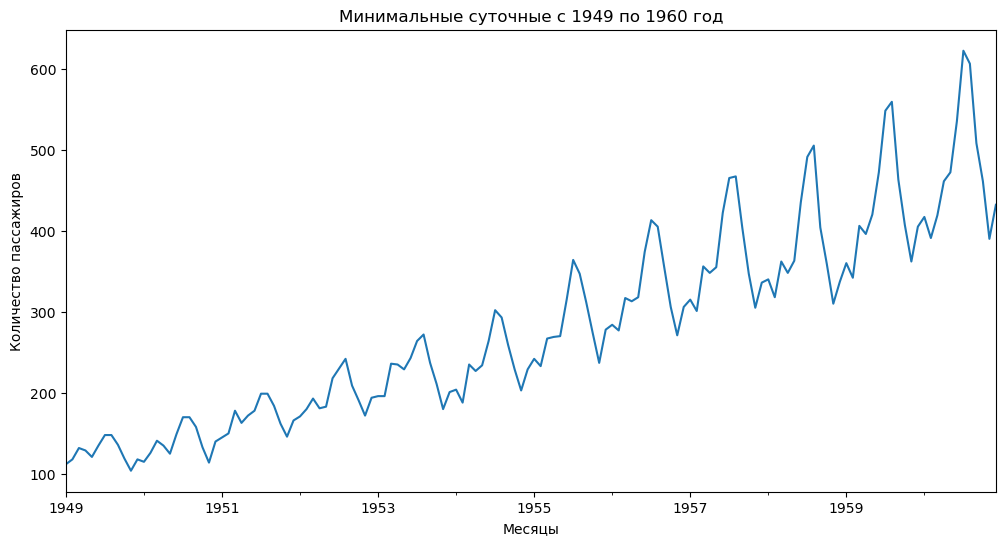

In [69]:
ax = df.plot(figsize = (12,6), legend = None)
ax.set(title = 'Минимальные суточные с 1949 по 1960 год', xlabel = 'Месяцы', ylabel = 'Количество пассажиров')

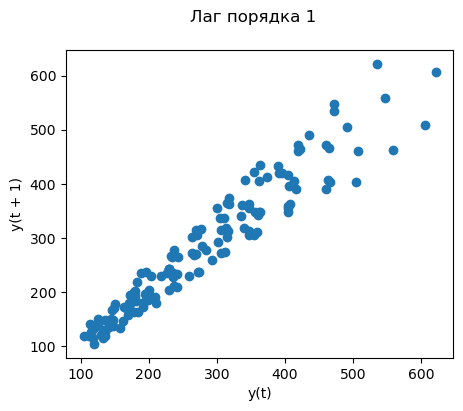

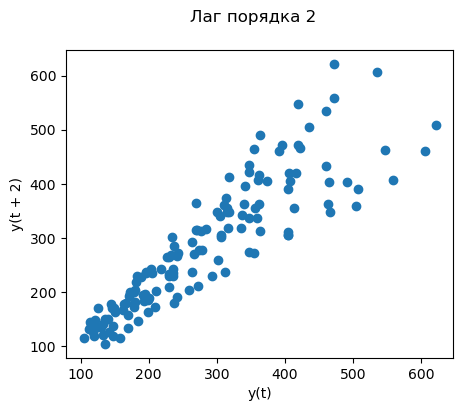

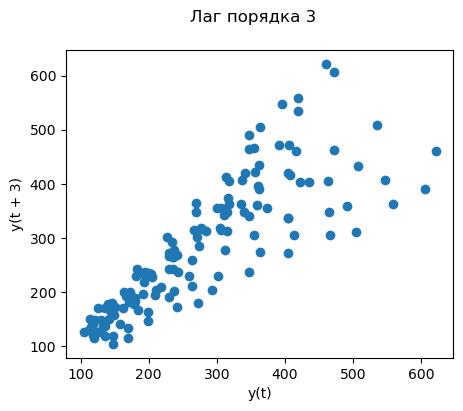

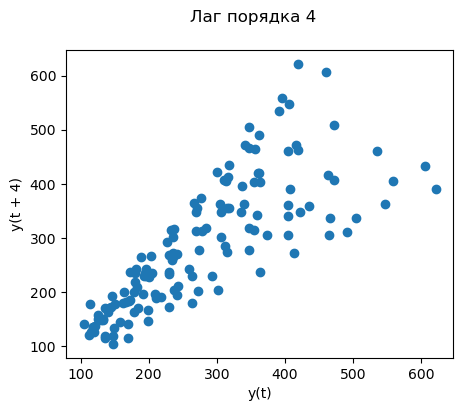

In [70]:
for i in range(1, 5):
    fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(5,4))
    fig.suptitle(f'Лаг порядка {i}')
    pd.plotting.lag_plot(df, lag=i, ax=ax)
    pyplot.show()

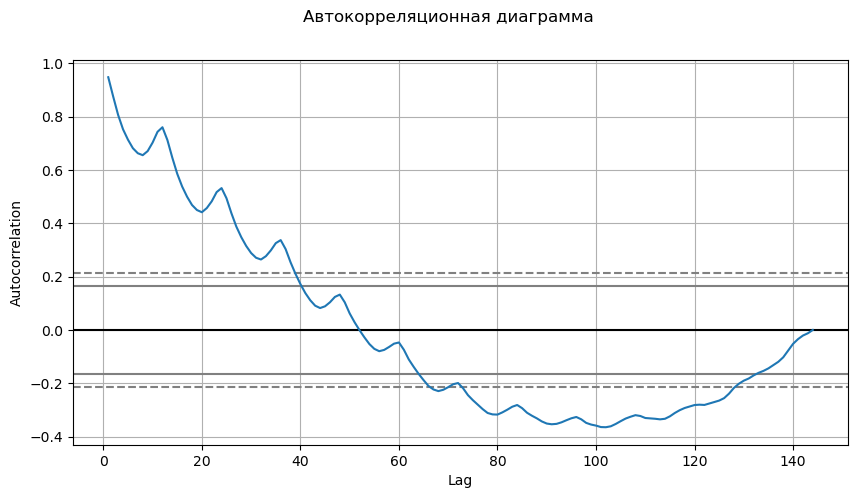

In [74]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Автокорреляционная диаграмма')
pd.plotting.autocorrelation_plot(df, ax=ax)
pyplot.show()

### Автокорреляционная функция

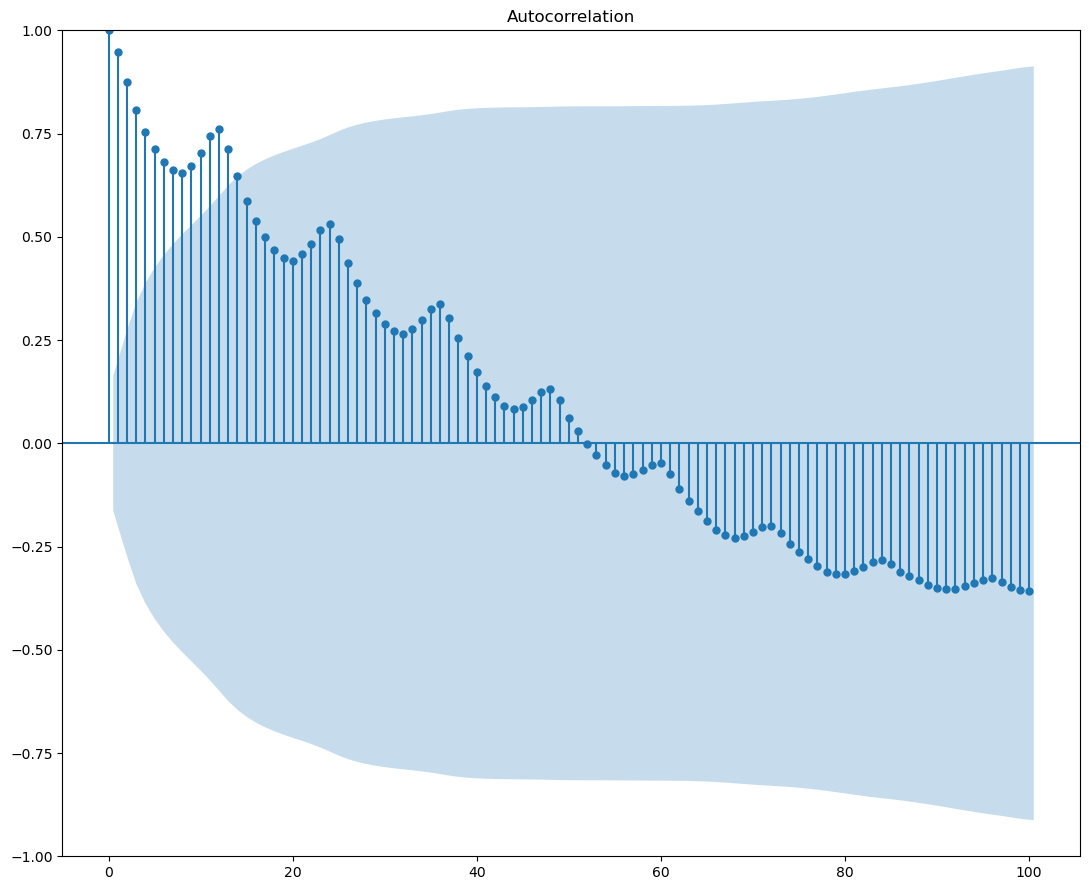

In [75]:
plot_acf(df, lags=100)
plt.tight_layout()

### Частичная автокорреляционная функция

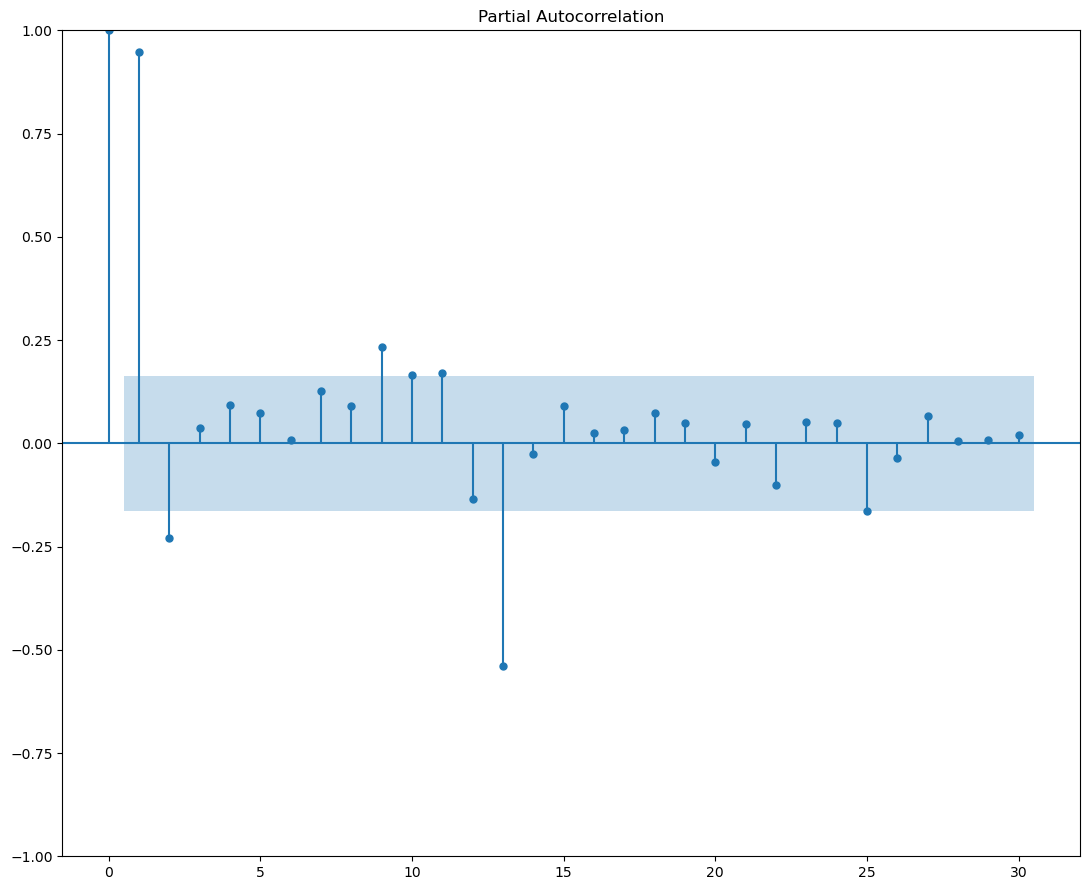

In [76]:
plot_pacf(df, lags=30, method='ywm')
plt.tight_layout()

### Декомпозиция временного ряда

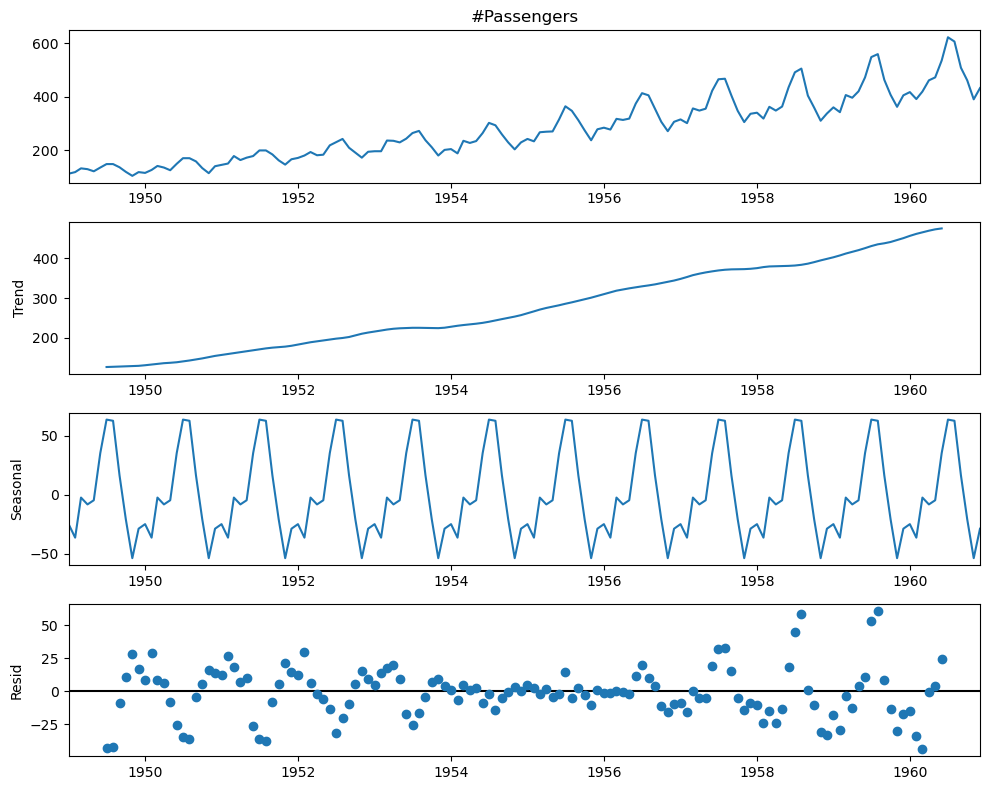

In [79]:
decomposed = seasonal_decompose(df['#Passengers'], model = 'add')
fig = decomposed.plot()
fig.set_size_inches((10, 8))
fig.tight_layout()
plt.show()

### Разделение временного ряда на обучающую и тестовую выборку

In [80]:
data_2 = df.copy()

In [81]:
# Целочисленная метка шкалы времени 
xnum = list(range(data_2.shape[0]))
# Разделение выборки на обучающую и тестовую
Y = data_2['#Passengers'].values
train_size = int(len(Y) * 0.7)
xnum_train, xnum_test = xnum[0:train_size], xnum[train_size:]
train, test = Y[0:train_size], Y[train_size:]
history_arima = [x for x in train]

### Прогнозирование временного ряда авторегрессионным методом (ARIMA)

In [82]:
# Параметры модели (p,d,q) 
arima_order = (2,1,0)
# Формирование предсказаний
predictions_arima = list()
for t in range(len(test)):
    model_arima = ARIMA(history_arima, order=arima_order)
    model_arima_fit = model_arima.fit()
    yhat_arima = model_arima_fit.forecast()[0]
    predictions_arima.append(yhat_arima)
    history_arima.append(test[t])
# Вычисление метрики RMSE
error_arima = mean_squared_error(test, predictions_arima, squared=False)

In [83]:
# Ошибка прогноза
np.mean(Y), error_arima

(280.2986111111111, 46.05700274647663)

In [84]:
# Записываем предсказания в DataFrame
data_2['predictions_ARIMA'] = (train_size * [np.NAN]) + list(predictions_arima)

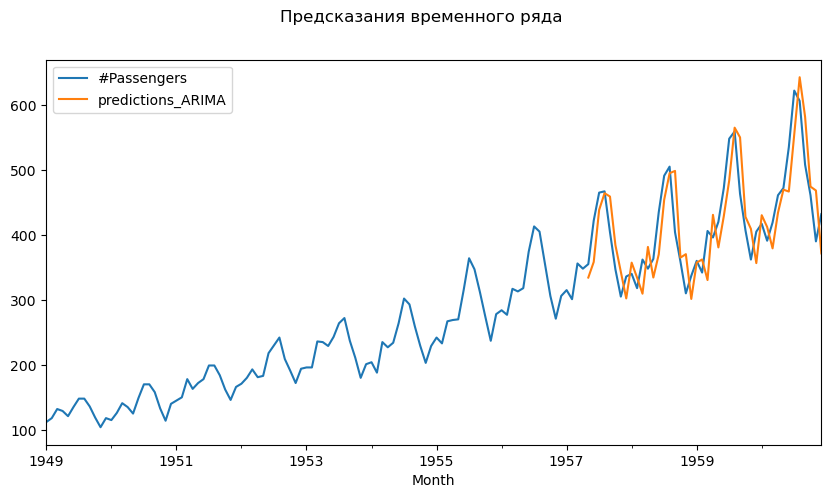

In [85]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда')
data_2.plot(ax=ax, legend=True)
pyplot.show()

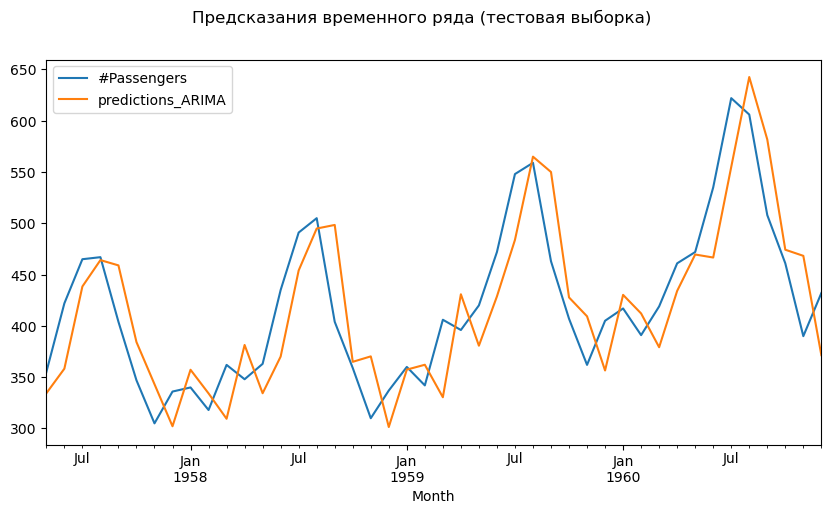

In [86]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

### Прогнозирование временного ряда методом символьной регресии

In [87]:
function_set = ['add', 'sub', 'mul', 'div', 'sin']
SR = SymbolicRegressor(population_size=500, metric='mse',
                               generations=70, stopping_criteria=0.01,
                               init_depth=(4, 10), verbose=1, function_set=function_set,
                               const_range=(-100, 100), random_state=0)

In [88]:
SR.fit(np.array(xnum_train).reshape(-1, 1), train.reshape(-1, 1))

C:\Users\sashu\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0   263.65      8.79975e+46       59          4935.14              N/A      2.05m
   1   141.19      4.16457e+14       72          4638.92              N/A     37.34s
   2    73.52      2.25505e+09       78          4579.99              N/A     27.39s
   3    64.77      1.21852e+15       71          3864.76              N/A     29.98s
   4    69.55      1.25496e+11       85          3715.16              N/A     25.23s
   5    68.89      4.26607e+10       81           3012.4              N/A     24.46s
   6    78.37      1.49839e+11       81           3012.4              N/A     27.43s
   7    79.09      8.20465e+13       92          3009.99              N/A     26.70s
   8    92.35      5.15147e+10      129             2754              N/A  

SymbolicRegressor(const_range=(-100, 100),
                  function_set=['add', 'sub', 'mul', 'div', 'sin'],
                  generations=70, init_depth=(4, 10), metric='mse',
                  population_size=500, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [90]:
# Предсказания
y_sr = SR.predict(np.array(xnum_test).reshape(-1, 1))
y_sr[:10]

array([337.4146303 , 339.60335004, 341.80088045, 344.00917373,
       346.2293616 , 348.4621579 , 350.70806389, 352.96747737,
       355.24075237, 357.5282324 ])

In [91]:
# Записываем предсказания в DataFrame
data_2['predictions_GPLEARN'] = (train_size * [np.NAN]) + list(y_sr)

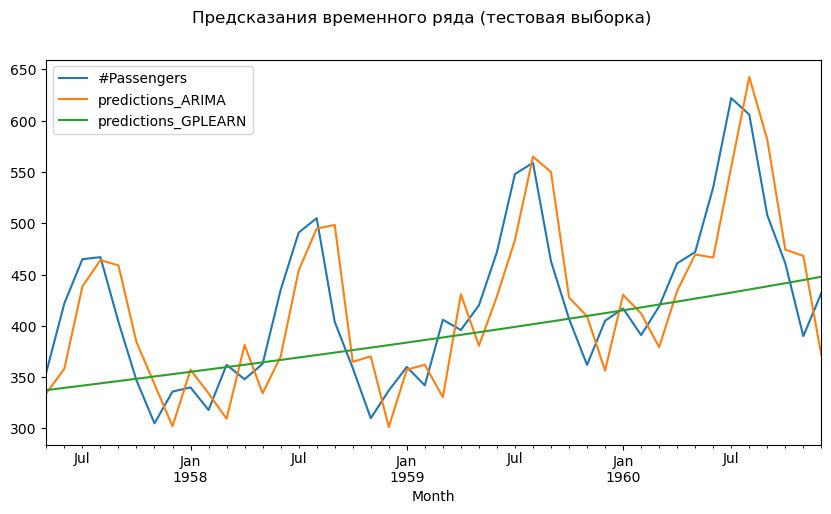

In [92]:
fig, ax = pyplot.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5))
fig.suptitle('Предсказания временного ряда (тестовая выборка)')
data_2[train_size:].plot(ax=ax, legend=True)
pyplot.show()

In [93]:
error_SR = mean_squared_error(test, y_sr, squared=False)

In [94]:
# Ошибка прогноза
np.mean(Y), error_SR

(280.2986111111111, 74.01335597682538)

### Качество прогноза моделей

In [95]:
def print_metrics(y_test, y_pred):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred, squared=False)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

In [96]:
print("ARIMA")
print_metrics(test, predictions_arima)

print("\nGPLEARN")
print_metrics(test, y_sr)

ARIMA
R^2: 0.6370252496418305
MSE: 46.05700274647663
MAE: 39.203629588574636

GPLEARN
R^2: 0.06264248635127811
MSE: 74.01335597682538
MAE: 53.97152719947599


#### Вывод: лучше оказалась ARIMA.